# Logistic regression trained with (batch) gradient descent

CSI4106 Introduction to Artificial Intelligence

Marcel Turcotte (School of Electrical Engineering and Computer Science,
University of Ottawa)  
2025-09-23

In this notebook, we develop a custom implementation of logistic
regression, employing batch gradient descent for training. Additionally,
we implement the `compute_roc_curve` and `compute_auc` functions.
Subsequently, we analyze two realistic yet straightforward datasets
utilizing scikit-learn libraries.

# Logistic Regression

The logistic regression implementation presented in the lecture notes
has some practical limitations, notably the need for users to manually
add a column of ones to the matrix $X$ to account for the intercept
term, $\theta_0$. Such a requirement can be considered suboptimal as it
exposes users to unnecessary implementation details. To address this
issue, I propose an object-oriented implementation that improves both
clarity and usability. This implementation efficiently utilizes the
[NumPy](https://numpy.org) library.

In [1]:
import numpy as np

class LogisticRegression:

    """
    A didactic implementation of binary logistic regression trained with
    (batch) gradient descent.

    Parameters
    ----------
    learning_rate : float, default=0.1
        Step size for gradient descent.
    max_iter : int, default=1000
        Number of gradient descent iterations.
    random_state : int, default=42
        Seed for reproducible initialization of parameters.

    Notes
    -----
    - This implementation expects binary labels {0, 1}.
    - The intercept (bias) term is added internally during `fit`.
    - For simplicity, there is no regularization and no early stopping.
    """

    def __init__(self, learning_rate: float = 0.1, max_iter: int = 1000, 
    random_state: int = 42):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state

        # Attributes set after fitting
        self._theta = None             # shape: (n_features + 1,) including intercept
        self._loss_history = None      # list of floats
        self._n_features = None        # number of features seen in X during fit (without intercept)
        self._fitted = False

    # ---------- Public API ----------

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LogisticRegression":
        """
        Fit the model parameters using gradient descent.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Feature matrix (NO intercept column; it will be added internally).
        y : array-like, shape (n_samples,)
            Binary target labels in {0, 1}.

        Returns
        -------
        self : LogisticRegression
        """
        X = self._as_2d_array(X, name="X")
        y = self._as_1d_array(y, name="y")
        self._check_binary_labels(y)

        m, n = X.shape
        self._n_features = n

        # Add intercept column of ones
        Xb = self._add_intercept(X)

        # Reproducible small random init (didactic: shows that init can matter)
        rng = np.random.default_rng(self.random_state)
        self._theta = rng.normal(loc=0.0, scale=1e-2, size=n + 1)

        self._loss_history = []

        # Gradient descent
        for _ in range(self.max_iter):
            z = Xb @ self._theta
            h = self._sigmoid(z)                       # predicted probabilities
            grad = (Xb.T @ (h - y)) / m                # gradient of binary cross-entropy
            self._theta -= self.learning_rate * grad   # update
            self._loss_history.append(self._bce_loss(h, y))

        self._fitted = True
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Return predicted probabilities for the positive class.

        Raises
        ------
        RuntimeError : if called before fit
        ValueError : if X has a different number of features than seen in fit
        """
        self._ensure_fitted()
        X = self._as_2d_array(X, name="X")
        self._ensure_same_n_features(X)

        Xb = self._add_intercept(X)
        return self._sigmoid(Xb @ self._theta)

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Return class predictions (0/1) using a probability threshold.

        Raises
        ------
        RuntimeError : if called before fit
        ValueError : if X has a different number of features than seen in fit
        """
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def get_loss_history(self) -> list:
        """
        Return a copy of the loss (binary cross-entropy) history collected during fit.

        Raises
        ------
        RuntimeError : if called before fit
        """
        self._ensure_fitted()
        return list(self._loss_history)

    # ---------- Internal helpers ----------

    @staticmethod
    def _sigmoid(z: np.ndarray) -> np.ndarray:
        # Numerically stable sigmoid
        # For large negative/positive z, np.exp is still fine here; clip to avoid log(0) later.
        return 1.0 / (1.0 + np.exp(-z))

    @staticmethod
    def _bce_loss(h: np.ndarray, y: np.ndarray) -> float:
        # Binary cross-entropy with epsilon for numerical stability
        eps = 1e-12
        h_clipped = np.clip(h, eps, 1.0 - eps)
        return float(-np.mean(y * np.log(h_clipped) + (1 - y) * np.log(1 - h_clipped)))

    @staticmethod
    def _as_2d_array(X, name="X") -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError(f"{name} must be a 2D array of shape (n_samples, n_features).")
        return X

    @staticmethod
    def _as_1d_array(y, name="y") -> np.ndarray:
        y = np.asarray(y, dtype=float)
        if y.ndim != 1:
            raise ValueError(f"{name} must be a 1D array of shape (n_samples,).")
        return y

    @staticmethod
    def _check_binary_labels(y: np.ndarray) -> None:
        values = np.unique(y)
        if not np.array_equal(values, [0, 1]) and not np.array_equal(values, [0.0, 1.0]):
            raise ValueError("y must contain only binary labels {0, 1}.")

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        ones = np.ones((X.shape[0], 1), dtype=float)
        return np.hstack([ones, X])

    def _ensure_fitted(self) -> None:
        if not self._fitted or self._theta is None:
            raise RuntimeError("This LogisticRegression instance is not fitted yet. Call `fit(X, y)` first.")

    def _ensure_same_n_features(self, X: np.ndarray) -> None:
        if X.shape[1] != self._n_features:
            raise ValueError(
                f"Feature mismatch: X has {X.shape[1]} features, but the model was fitted with {self._n_features}."
            )

# Example 1

## Step 0: Import librairies, set global variables

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

seed=42

## Step 1: Create a toy dataset

In [3]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=2.5, random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Visualizing the training set.

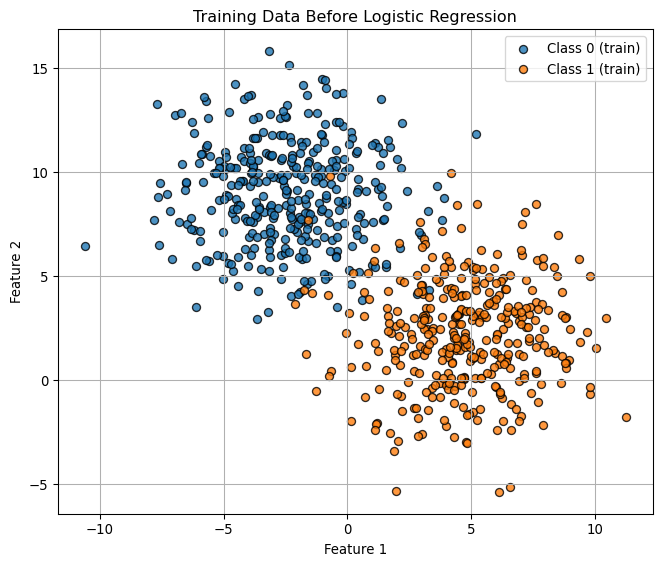

In [4]:
plt.figure(figsize=(7, 6))

plt.scatter(
    X_train[y_train == 0, 0], X_train[y_train == 0, 1],
    color="tab:blue", marker="o", edgecolor="k", alpha=0.8, label="Class 0 (train)"
)
plt.scatter(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1],
    color="tab:orange", marker="o", edgecolor="k", alpha=0.8, label="Class 1 (train)"
)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Training Data Before Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 2: Train our LogisticRegression class

In [5]:
model = LogisticRegression(learning_rate=0.1, max_iter=500, random_state=42)
model.fit(X_train, y_train)

In [6]:
# --- Step 3: Predictions and classification report ---
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       151
           1       0.99      0.98      0.99       149

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


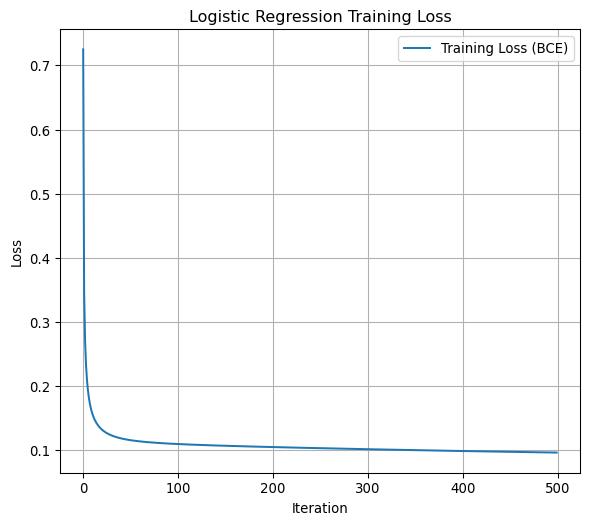

In [7]:
# --- Step 4: Plot the loss history ---

losses = model.get_loss_history()

plt.figure(figsize=(7, 6)) 
plt.plot(losses, label="Training Loss (BCE)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression Training Loss")
plt.legend()
plt.grid(True)
plt.show()

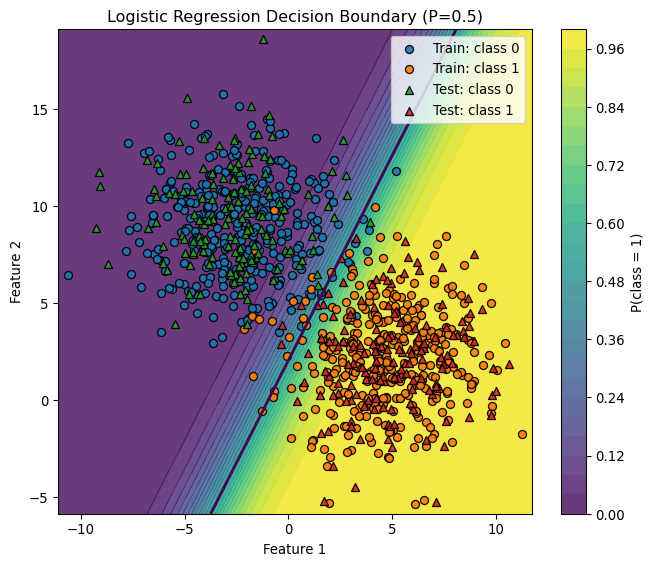

In [8]:
# --- Step 5: Decision boundary (2D) ---
# Works because we used n_features=2 above.
# If you use more than 2 features, select two columns to visualize (e.g., X[:, :2]).

def plot_decision_boundary(model, X_train, y_train, X_test, y_test, h=0.02):
    """
    Plot probability heatmap, 0.5 decision contour, and data points.

    Parameters
    ----------
    model : fitted LogisticRegression (our class)
    X_train, y_train : training data (2D features)
    X_test, y_test   : test data (2D features)
    h : float, grid step size (smaller -> finer mesh)
    """
    # 1) Build a mesh over the feature space (with padding for nicer margins)
    x_min = min(X_train[:, 0].min(), X_test[:, 0].min()) - 0.5
    x_max = max(X_train[:, 0].max(), X_test[:, 0].max()) + 0.5
    y_min = min(X_train[:, 1].min(), X_test[:, 1].min()) - 0.5
    y_max = max(X_train[:, 1].max(), X_test[:, 1].max()) + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 2) Predict probabilities on the grid (class 1)
    Z = model.predict_proba(grid).reshape(xx.shape)

    # 3) Plot
    plt.figure(figsize=(7, 6))

    # Heatmap of P(y=1|x); levels=25 for smooth look
    cntr = plt.contourf(xx, yy, Z, levels=25, alpha=0.8)
    cbar = plt.colorbar(cntr)
    cbar.set_label("P(class = 1)")

    # Decision boundary at probability 0.5
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=2)

    # Training points
    plt.scatter(
        X_train[y_train == 0, 0], X_train[y_train == 0, 1],
        marker="o", edgecolor="k", alpha=0.9, label="Train: class 0"
    )
    plt.scatter(
        X_train[y_train == 1, 0], X_train[y_train == 1, 1],
        marker="o", edgecolor="k", alpha=0.9, label="Train: class 1"
    )

    # Test points (different marker)
    plt.scatter(
        X_test[y_test == 0, 0], X_test[y_test == 0, 1],
        marker="^", edgecolor="k", alpha=0.9, label="Test: class 0"
    )
    plt.scatter(
        X_test[y_test == 1, 0], X_test[y_test == 1, 1],
        marker="^", edgecolor="k", alpha=0.9, label="Test: class 1"
    )

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary (P=0.5)")
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X_train, y_train, X_test, y_test)

# Implementating ROC/AUC

In [9]:
def compute_roc_curve(y_true, y_scores, thresholds):
    tpr_list, fpr_list = [], []
    for thresh in thresholds:
        # Classify as positive if predicted probability >= threshold
        y_pred = (y_scores >= thresh).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)
        
    tpr_list.reverse()
    fpr_list.reverse()

    return np.array(fpr_list), np.array(tpr_list)

## Implementation: AUC ROC

In [10]:
def compute_auc(fpr, tpr):
    """
    Compute the Area Under the Curve (AUC) using the trapezoidal rule.
    
    fpr: array of false positive rates
    tpr: array of true positive rates
    """
    return np.trapezoid(tpr, fpr)

## Example: Plot

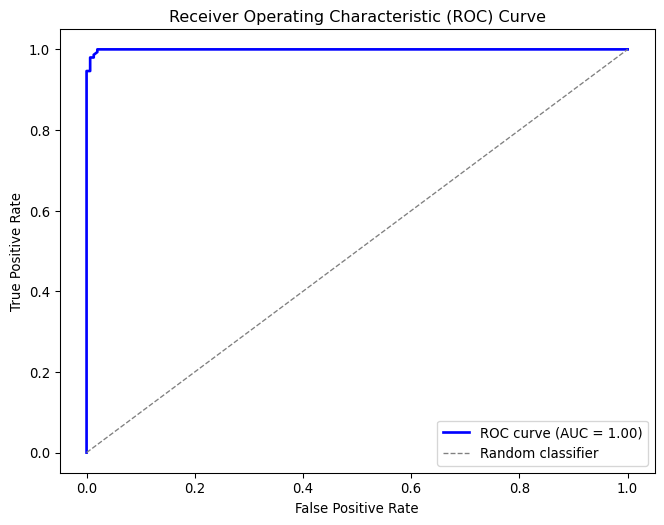

In [11]:
# Compute predicted probabilities for the positive class on the test set
y_probs = model.predict_proba(X_test)

# Define a set of threshold values between 0 and 1 (e.g., 100 equally spaced thresholds)
thresholds = np.linspace(0, 1, 100)

# Compute the ROC curve (FPR and TPR for each threshold)
fpr, tpr = compute_roc_curve(y_test, y_probs, thresholds)
auc_value = compute_auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Example 2 (breast cancer)

In this example, we use logistic regression from the scikit-learn
library, and the breast cancer dataset, also available through
scikit-learn. You are encouraged to modify the provided code to evaluate
whether the previously introduced model achieves comparable performance.
As can be seen, in this example, the classes are easily seperable by a
linear decision boundary.

Dataset shape: (569, 30), Labels: [212 357]
Feature names (first 5): ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


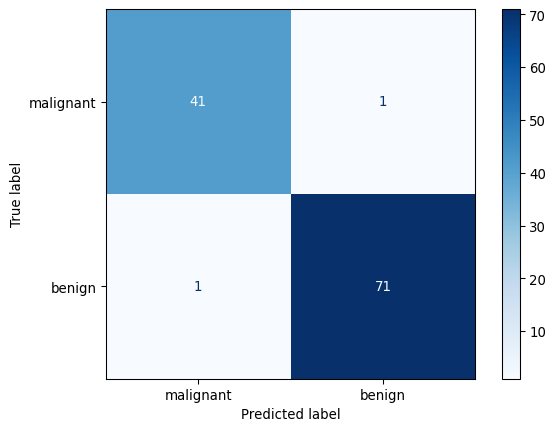


Top 5 influential features:
worst texture              -1.255
radius error               -1.083
worst concave points       -0.954
worst area                 -0.948
worst radius               -0.948

In [12]:
# Goal: Classify tumors as malignant (1) or benign (0)
# Dataset: sklearn.datasets.load_breast_cancer
# Model: Logistic Regression (scikit-learn)

# 1. Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
print(f"Dataset shape: {X.shape}, Labels: {np.bincount(y)}")
print("Feature names (first 5):", data.feature_names[:5])

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Scale features (important for gradient-based methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Logistic Regression
clf = SKLogisticRegression(max_iter=5000, random_state=42)
clf.fit(X_train_scaled, y_train)

# 5. Evaluate
y_pred = clf.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap="Blues")
plt.show()

# 6. Inspect model coefficients
# (Shows how each feature contributes to decision boundary)
coef = clf.coef_[0]
feature_importance = sorted(zip(data.feature_names, coef), key=lambda x: abs(x[1]), reverse=True)

print("\nTop 5 influential features:")
for name, weight in feature_importance[:5]:
    print(f"{name:25s}  {weight:.3f}")

# Example 3 (Pima Indians Diabetes)

In this third example, logistic regression faces a greater challenge.
Achieving a true positive rate (TPR) or recall of 85% necessitates a
significant trade-off, resulting in a false positive rate (FPR) where
31% of true negative instances are incorrectly classified as positive.

Loaded OpenML dataset: 'diabetes' with shape (768, 8)

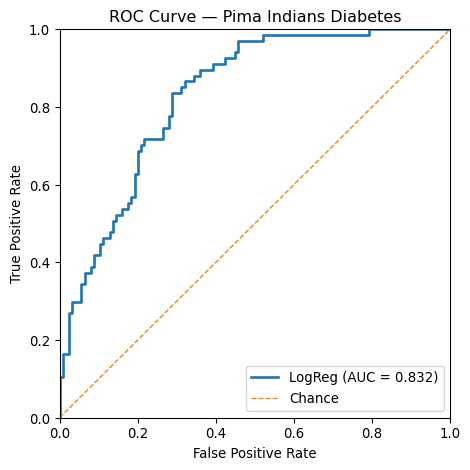

Closest TPR: 0.851
Corresponding FPR: 0.312
Threshold: 0.271

In [13]:
# ROC demo: Logistic Regression on Pima Indians Diabetes
# ------------------------------------------------------
# - Fetches the Pima dataset from OpenML
# - Trains a SKLogisticRegression
# - Plots ROC curve and reports AUC

import warnings
warnings.filterwarnings("ignore")

# 1) Load Pima from OpenML (try a few common names to be robust across mirrors)
candidates = ["diabetes", "pima-indians-diabetes", "diabetes_binary", "diabetes_numeric"]
X, y, feat_names = None, None, None

for name in candidates:
    try:
        ds = fetch_openml(name=name, as_frame=True)
        df = ds.frame.copy()
        # Identify target column candidates
        for target_col in ["class", "Outcome", "diabetes", "target"]:
            if target_col in df.columns:
                y = df[target_col]
                X = df.drop(columns=[target_col])
                feat_names = X.columns.tolist()
                # Ensure binary labels {0,1}
                if y.dtype.kind in "OUS":
                    y = y.astype(str).str.lower().replace({
                        "tested_positive": 1, "tested_negative": 0,
                        "pos": 1, "neg": 0, "positive": 1, "negative": 0,
                        "yes": 1, "no": 0
                    })
                y = y.astype(int)
                break
        if X is not None and len(np.unique(y)) == 2:
            print(f"Loaded OpenML dataset: '{name}' with shape {X.shape}")
            break
    except Exception:
        continue

if X is None:
    raise RuntimeError("Could not load the Pima dataset from OpenML. "
                       "Check your internet connection or try again later.")

# 2) Train/test split (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 3) Scale features (helps LR optimization)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 4) Train Logistic Regression
clf = SKLogisticRegression(max_iter=2000, random_state=42)
clf.fit(X_train_s, y_train)

# 5) ROC curve & AUC
y_score = clf.predict_proba(X_test_s)[:, 1]     # probability of positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

# 6) Plot
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, lw=2, label=f"LogReg (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], lw=1, linestyle="--", label="Chance")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Pima Indians Diabetes")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Target TPR
target_tpr = 0.85

# Find index of TPR closest to target
idx = np.argmin(np.abs(tpr - target_tpr))

print(f"Closest TPR: {tpr[idx]:.3f}")
print(f"Corresponding FPR: {fpr[idx]:.3f}")
print(f"Threshold: {thresholds[idx]:.3f}")